In [73]:
import xml.etree.cElementTree as etree
import re
from tqdm import tqdm
import os
import nltk
from bs4 import BeautifulSoup
from html2text import html2text 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
np.random.seed(7)

In [74]:
def clean_html(html):
    """
    Copied from NLTK package.
    Remove HTML markup from the given string.

    :param html: the HTML string to be cleaned
    :type html: str
    :rtype: str
    """

    # First we remove inline JavaScript/CSS:
    cleaned = re.sub(r"(?is)<(script|style).*?>.*?(</\1>)", "", html.strip())
    # Then we remove html comments. This has to be done before removing regular
    # tags since comments can contain '>' characters.
    cleaned = re.sub(r"(?s)<!--(.*?)-->[\n]?", "", cleaned)
    # Next we can remove the remaining tags:
    cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
    # Finally, we deal with whitespace
    cleaned = re.sub(r"&nbsp;", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)
    return cleaned.strip()


In [75]:
def loadFiles(directory):
    DEBUG =False
    l = []
    for file in os.listdir(directory):
        data = directory + file
        if DEBUG : print (data)
        l.append(data)
    l=sorted(l)
    
    return l

In [76]:
cancer_file_loc = "./Dataset/train/cancer/"
non_cancer_file_loc = "./Dataset/train/noncancer/" 

In [77]:
files_cancer = loadFiles(cancer_file_loc)
files_noncancer = loadFiles(non_cancer_file_loc)

In [78]:
cancer=[]
for i in tqdm(files_cancer):
    xmlDoc = open(i, 'r')
    xmlDocData = xmlDoc.read()
    html=xmlDocData
    cleanhtml = clean_html(html)
    text = html2text(cleanhtml)
    soup = BeautifulSoup(html,"lxml")
    text2 = soup.get_text()
    cancer.append([text2,'c'])

100%|██████████| 300/300 [00:50<00:00,  5.95it/s]


In [79]:
noncancer=[]
for i in tqdm(files_noncancer):
    xmlDoc = open(i, 'r')
    xmlDocData = xmlDoc.read()
    html=xmlDocData
    cleanhtml = clean_html(html)
    text = html2text(cleanhtml)
    soup = BeautifulSoup(html,"lxml")
    text2 = soup.get_text()
    noncancer.append([text2,'nc'])

100%|██████████| 150/150 [00:14<00:00, 10.45it/s]


In [80]:
import pandas as pd

In [81]:
cnT  = pd.DataFrame(cancer,columns=['text','lable'])
NcnT = pd.DataFrame(noncancer,columns=['text','lable'])

In [82]:
cm = [cnT,NcnT]
df = pd.concat(cm,ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

In [83]:
df.head(5)

,text,lable
0,Case Reports ImmunolCase Reports ImmunolCRIICa...,nc
1,Case Reports ImmunolCase Reports ImmunolCRIICa...,nc
2,Cancer Immunol ImmunotherCancer Immunol. Immun...,c
3,Cancer Biol MedCancer Biol MedCBMCancer Biolog...,c
4,Cancer ImagingCancer ImagingCancer Imaging1740...,c


# Clean Text Data

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [85]:
data  = df
data  = np.array(data['text'])
lable  = df['lable'].map({"c":1,"nc":0})
lable  = np.array(lable)

In [86]:
def cleanDatset(holdtext):
    dataset=[]
    for i in tqdm(holdtext):        
        sent_tokenize_list = sent_tokenize(i)
        tokenized_reports = [word_tokenize(report) for report in sent_tokenize_list]
        regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html
        tokenized_reports_no_punctuation = []
        
        for review in tokenized_reports:
            new_review = []
            for token in review: 
                new_token = regex.sub(u'', token)
                if not new_token == u'':
                    new_review.append(new_token)
            tokenized_reports_no_punctuation.append(new_review)    
        tokenized_reports_no_stopwords = []
        for report in tokenized_reports_no_punctuation:
            new_term_vector = []
            for word in report:
                if not word in stopwords.words('english'):
                    new_term_vector.append(word)
            tokenized_reports_no_stopwords.append(new_term_vector)
        v=[]
        for i in tokenized_reports_no_stopwords:
            v.append(" ".join(i))
        gt=" ".join(v)
        text2=''.join([i for i in gt if not i.isdigit()])
        toker = RegexpTokenizer(r'((?<=[^\w\s])\w(?=[^\w\s])|(\W))+', gaps=True)
        fnlTxt=''.join(toker.tokenize(text2))
        dataset.append(" ".join(fnlTxt.split()))
    return dataset

In [87]:
dataset = cleanDatset(data)

100%|██████████| 450/450 [05:40<00:00,  1.32it/s]


In [88]:
t1=pd.DataFrame(dataset,columns=["text"])
t2=pd.DataFrame(lable,columns=["lable"])

In [89]:
trData = pd.concat([t1,t2],axis=1)
trData.head(10)

,text,lable
0,Case Reports ImmunolCase Reports ImmunolCRIICa...,0
1,Case Reports ImmunolCase Reports ImmunolCRIICa...,0
2,Cancer Immunol ImmunotherCancer Immunol Immuno...,1
3,Cancer Biol MedCancer Biol MedCBMCancer Biolog...,1
4,Cancer ImagingCancer ImagingCancer ImagingBioM...,1
5,Cancer ImagingCancer ImagingCICancer ImagingCa...,1
6,Cancer ImagingCancer ImagingCancer ImagingBioM...,1
7,Clin Drug InvestigClin Drug InvestigClinical D...,0
8,Cancer ImagingCancer ImagingCancer ImagingBioM...,1
9,Cancer ImagingCICancer ImagingCancer ImagingeM...,1


# Feature Extraction

In [90]:
holdtext = np.array(trData['text'])

In [91]:
vect = CountVectorizer(max_features=3000)
vect.fit(holdtext)
simple_train_dtm = vect.transform(holdtext)
std   =  simple_train_dtm.toarray()

In [92]:
tab = pd.DataFrame(simple_train_dtm.toarray(),columns=vect.get_feature_names())
tab.head(10)

,ab,abdomen,abdominal,ability,ablation,ablative,able,abnormal,abnormalities,abnormality,...,yield,york,young,younger,zebrafish,zero,zr,μgml,μl,μm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,6,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,2,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,2,2,5,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Feature Reduction < Select Important Features >

In [93]:
from sklearn.decomposition import PCA

In [94]:
def dimensionReduction(nof):
    pca = PCA(n_components=nof)
    fit = pca.fit(std)
    tx = pd.DataFrame(pca.components_,columns=tab.columns)
    td  = np.array(tx)
    tmp = td[-1]
    newA = np.copy(tmp)
    pos=[]
    for i in range(nof):
        mx = np.where(newA==np.max(newA))
        pos.append(mx[0][0])
        newA[mx[0][0]]=-999
    newcolname = tx.columns[pos]
    val = []
    for i in newcolname:
        val.append(i)
    redu_features = tab[val]
    #print(tab.shape)
    #print(redu_features.shape)
    return redu_features

# Split to train-test

In [95]:
redu_features = dimensionReduction(500)
redu_features.head(10)

,able,absolute,ab,affects,absorption,academy,pe,abnormality,ablation,activated,...,emotional,mabs,fentanyl,observed,obstruction,surgery,process,challenging,bowel,fractures
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,4,4,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,1,2,0
2,0,1,0,0,0,3,0,0,0,2,...,0,0,0,8,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2,0,4,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,2,0,0,0
5,1,0,0,1,0,0,0,0,1,0,...,0,0,0,1,1,1,0,2,1,0
6,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
7,2,1,1,0,1,1,0,0,0,0,...,1,0,1,1,0,0,1,1,53,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2,0,0,2,0


In [98]:
X = np.array(redu_features)
y = np.array(trData['lable'].astype('int'))

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

# SVM

In [100]:
from sklearn import svm

In [101]:
clf = svm.SVC() # svm classifer

In [102]:
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [103]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_curve

In [104]:
result1 = clf.predict(X_test)

In [105]:
confusion_matrix(y_test,result1)

array([[ 17,  29],
       [  0, 103]])

In [106]:
accuracy_score(y_test,result1)

0.80536912751677847

In [107]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [108]:
y_score = clf.decision_function(X_test)

In [109]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.99


<IPython.core.display.Javascript object>


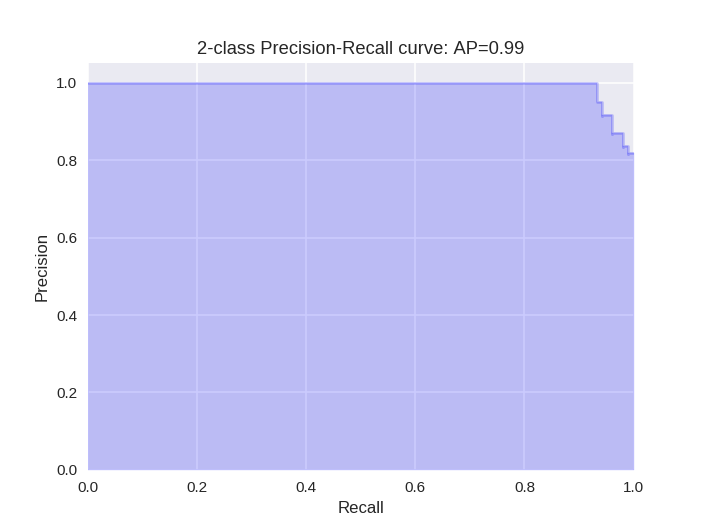

In [110]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

# Boosted tree

In [111]:
import xgboost as xgb

In [112]:
model_xgboost = xgb.XGBClassifier() # boosted tree classifire
model_xgboost.fit(X_train,y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [113]:
pred = model_xgboost.predict(X_test)
print(accuracy_score(pred,y_test))

0.979865771812


In [114]:
confusion_matrix(y_test,pred)

array([[ 43,   3],
       [  0, 103]])

In [115]:
average_precision = average_precision_score(y_test,pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.99


<IPython.core.display.Javascript object>


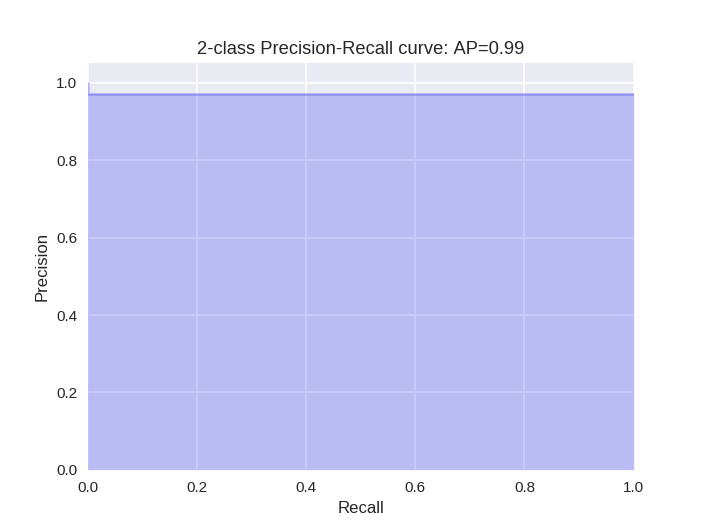

In [116]:
precision, recall, _ = precision_recall_curve(y_test,pred )

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

# Analysis of effect Reduce the dimension of feature and compare between SVM and Boosted Tree


In [117]:
# Total extracted dimesion is 3000

In [118]:
v= np.arange(10,3005,500)
sample = sorted(v,reverse=True)
sample

[2510, 2010, 1510, 1010, 510, 10]

In [119]:
svmAc  = []
boostAcc = []
for i in tqdm(sample):
    redu = dimensionReduction(i)
    X = np.array(redu)
    y = np.array(trData['lable'].astype('int'))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)
    clf.fit(X_train, y_train)
    result1 = clf.predict(X_test)
    svmAc.append(accuracy_score(y_test,result1))
    model_xgboost.fit(X_train,y_train) 
    pred = model_xgboost.predict(X_test)
    boostAcc.append(accuracy_score(pred,y_test))

100%|██████████| 6/6 [00:10<00:00,  1.42s/it]


In [121]:
import plotly.plotly as py
import plotly.graph_objs as go

In [122]:
trace1 = go.Bar(
    x = sample,
    y = svmAc,
    name='SVM_acc'
)
trace2 = go.Bar(
    x = sample,
    y = boostAcc,
    name='Boost_acc'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title='Accuracy_Changes_by_reduce_the_feature',
    xaxis=dict(
        title='No_of_feature',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Accuracy',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Accuracy_Changes_by_reduce_the_feature')

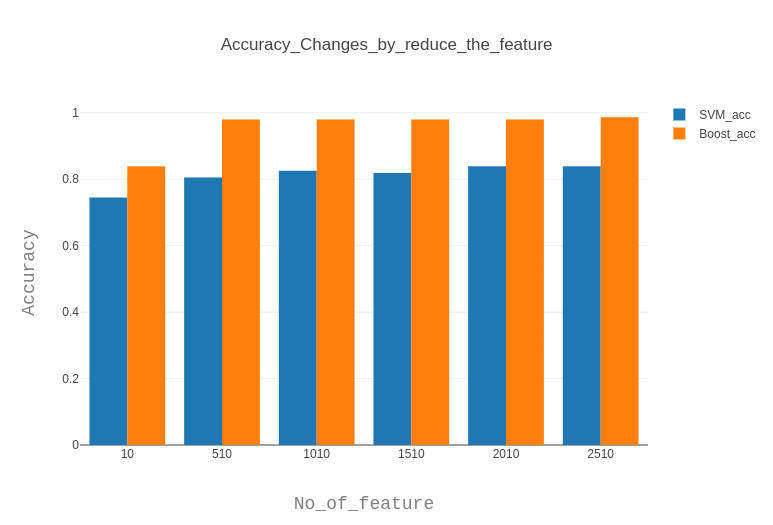

In [123]:
from IPython.display import Image
Image(filename='fig.png')